# Plot experiment results

In [1]:
import collections
import os
import json
import pathlib
import typing as t
import pickle

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd


PATH_RESOURCES = "../train_statistics"
OUTPUT_DIR = "./figures"


pathlib.Path(OUTPUT_DIR).mkdir(exist_ok=True, parents=True)


sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    font_scale=1.5,
)


def all_cls_attrs(attr: str) -> list[str]:
    return [f"{attr}_{i}" for i in range(4)]

In [2]:
def read_results_from_json(vocab_size: int) -> pd.DataFrame:
    df = []

    for layer_count in (2, 4, 6, 8, 10, 12):
        try:
            file_uri = os.path.join(
                PATH_RESOURCES,
                f"{layer_count}_{vocab_size}_layer_model",
                "all_results.json",
            )

            with open(file_uri, "r") as f:
                df_col = pd.DataFrame.from_dict(
                    {layer_count: json.load(f)},
                    orient="index",
                )

        except FileNotFoundError:
            continue

        df.append(df_col)

    df = pd.concat(df).T
    return df


def build_annot(ax, subset):
    max_vals = subset.values.max(axis=0)
    annot = np.full_like(subset.values, fill_value=None, dtype=object)

    n, m = subset.shape

    for i in range(n):
        for j in range(m):
            annot[i, j] = f"{subset.values[i, j]:.2f}"
            if np.isclose(subset.values[i, j], max_vals[j]):
                annot[i, j] = f"{annot[i, j]}"

    return annot


def add_cell_highlight(ax, subset, **kwargs) -> np.ndarray:
    if isinstance(subset, pd.DataFrame):
        subset = subset.values

    max_vals = subset.max(axis=0)

    n, m = subset.shape

    rectangle_kwargs = dict(
        width=1,
        height=1,
        edgecolor="orange",
        fill=False,
        lw=2,
        linestyle="solid",
    )

    rectangle_kwargs.update(kwargs)

    highlighted_cells = np.zeros_like(subset, dtype=bool)

    for i in range(n):
        for j in range(m):
            if np.isclose(subset[i, j], max_vals[j], atol=0.005, rtol=0.0):
                rect = plt.Rectangle(xy=(j, i), **rectangle_kwargs)
                ax.add_patch(rect)
                highlighted_cells[i, j] = True

    return highlighted_cells


def apply_delta_annot(ax, subset):
    n, m = subset.shape

    cols = np.full_like(subset, fill_value=None, dtype=object)

    children = [child for child in ax.get_children() if isinstance(child, plt.Text)]

    for i in range(n):
        for j in range(m):
            cols[i, j] = children[i * m + j].get_color()

    for i in range(1, n):
        for j in range(m):
            dlt_val = subset.values[i, j] - subset.values[i - 1, j]
            sign = "+" if dlt_val >= 0 else "-"
            ax.annotate(
                f"\n($\Delta:${sign}{abs(dlt_val):.2f})",
                xy=(j, i),
                xytext=(8, 20),
                color=cols[i, j],
                fontsize=11,
                textcoords="offset points",
            )


def plot_heatmap(
    df: t.Optional[pd.DataFrame] = None,
    vocab_size: t.Optional[int] = None,
    save_in_disk: bool = True,
    height: float = 8.4,
    width: float = 8.0,
    scale: float = 100.0,
    highlight_best_cells: bool = True,
    display_cell_delta: bool = True,
    colormap_precision: str = "Blues",
    colormap_recall: str = "Purples",
    suptitle: t.Optional[str] = None,
    heatmap_limits: tuple[float, float] = (0.6, 1.0),
    output_file_name: t.Optional[str] = None,
) -> pd.DataFrame:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * width, height), sharex=True, sharey=True)

    ax_aspect = "equal"
    ax1.set_aspect(ax_aspect)
    ax2.set_aspect(ax_aspect)

    if df is None:
        df = read_results_from_json(vocab_size)
        df = (scale * df).round(decimals=2)

    subset_1 = df.loc[["test_macro_precision", *all_cls_attrs("test_per_cls_precision")]]
    subset_2 = df.loc[["test_macro_recall", *all_cls_attrs("test_per_cls_recall")]]

    rotation = 0
    xticklabels = ["Macro\n(All classes)", "No-op", "Segment", "Noise\n(start)", "Noise\n(end)"]
    yticklabels = df.columns

    vmin, vmax = heatmap_limits

    conf_heatmap = dict(
        square=True,
        linewidths=2,
        robust=True,
        xticklabels=xticklabels,
        yticklabels=yticklabels,
        fmt="",
        vmax=scale * vmax,
        vmin=scale * vmin,
        cbar_kws=dict(),
    )

    if suptitle is None:
        suptitle = f"Per-class, Per-layer metrics (dictionary size: {vocab_size} subwords)"

    fig.suptitle(suptitle, fontsize=12)

    hm_1 = sns.heatmap(
        subset_1.T,
        ax=ax1,
        **conf_heatmap,
        annot=build_annot(ax1, subset_1.T),
        cmap=colormap_precision,
    )

    hm_1.set_xlabel("Classes")
    hm_1.set_ylabel("Layer count")
    hm_1.set_title("Precision (%)", fontsize=16)

    hm_2 = sns.heatmap(
        subset_2.T,
        ax=ax2,
        **conf_heatmap,
        annot=build_annot(ax2, subset_2.T),
        cmap=colormap_recall,
    )

    hm_2.set_xlabel("Classes")
    hm_2.set_title("Recall (%)", fontsize=16)

    if highlight_best_cells:
        add_cell_highlight(ax1, subset_1.T)
        add_cell_highlight(ax2, subset_2.T)

    ax1.set_xticklabels(labels=xticklabels, rotation=rotation)
    ax1.set_yticklabels(labels=yticklabels, rotation=rotation)
    ax1.invert_yaxis()

    if display_cell_delta:
        apply_delta_annot(ax1, subset_1.T)
        apply_delta_annot(ax2, subset_2.T)

    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    if save_in_disk:
        if output_file_name is None:
            output_file_name = f"{vocab_size}_heatmap_precision_recall.pdf"

        if not output_file_name.endswith(".pdf"):
            output_file_name += ".pdf"

        fig.savefig(
            fname=os.path.join(OUTPUT_DIR, output_file_name),
            transparent=True,
            format="pdf",
        )

    return df, (ax1, ax2)


def plot_diff_heatmap(
    df_1: pd.DataFrame,
    df_2: pd.DataFrame,
    layers: t.Optional[t.Sequence[int]] = None,
    save_in_disk: bool = True,
) -> pd.DataFrame:
    _, m_1 = df_1.shape
    _, m_2 = df_2.shape

    df_diff = df_1.iloc[:, :m_1] - df_2.iloc[:, :m_2]

    if layers is not None:
        df_diff = df_diff.loc[:, layers]

    df_diff, (ax1, ax2) = plot_heatmap(
        df=df_diff,
        save_in_disk=save_in_disk,
        height=1.4 * len(layers) if layers is not None else 8.4,
        display_cell_delta=False,
        highlight_best_cells=False,
        colormap_precision="RdBu",
        colormap_recall="PiYG",
        suptitle=f"Per-class, Per-layer metrics (6k-subword $-$ 12k-subword models)",
        heatmap_limits=(-0.05, 0.05),
        output_file_name="performance_diff_between_dicts.pdf",
    )

    return df_diff, (ax1, ax2)

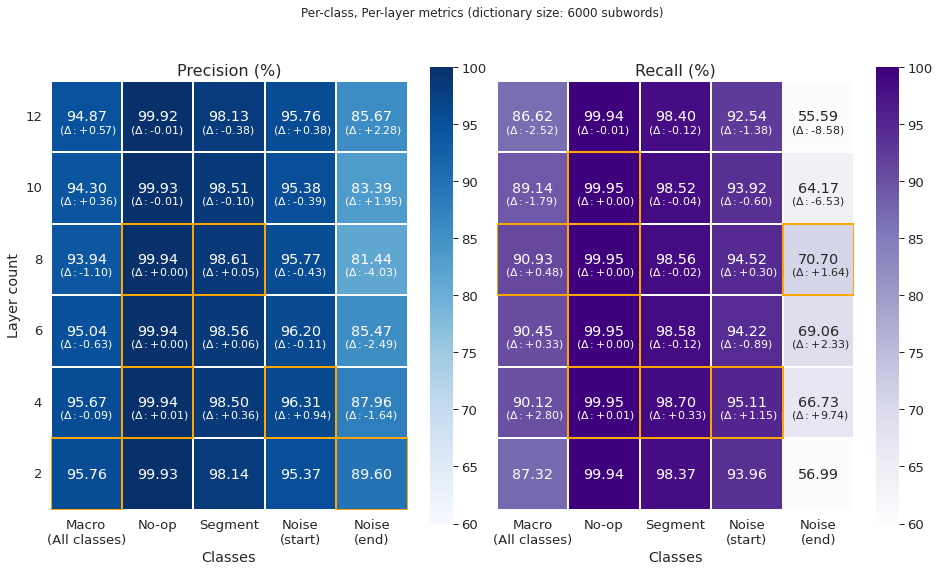

In [3]:
df_6000, _ = plot_heatmap(vocab_size=6000)

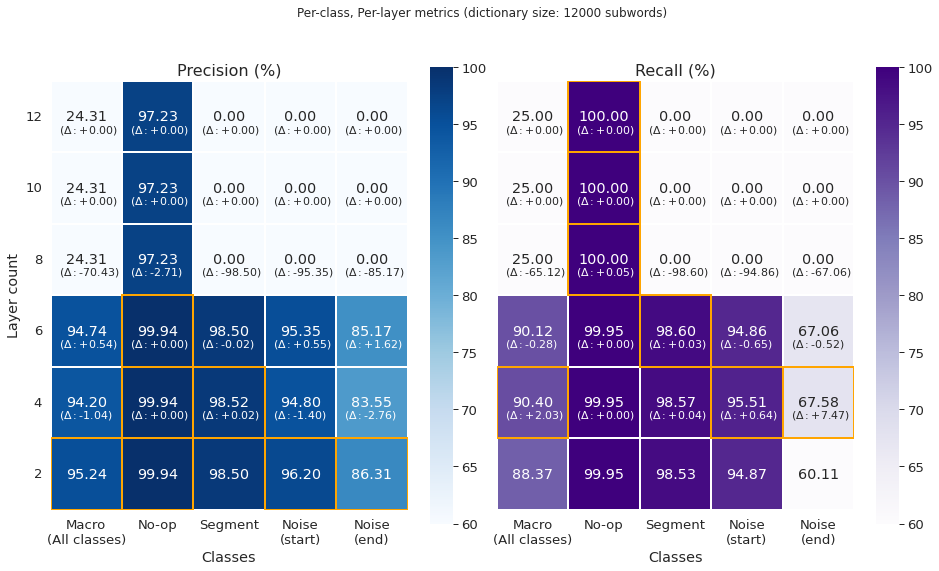

In [4]:
df_12000, _ = plot_heatmap(vocab_size=12000)

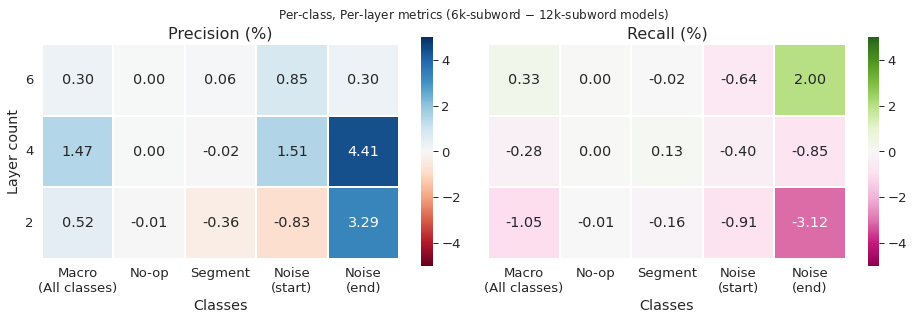

In [5]:
df_diff, _ = plot_diff_heatmap(
    df_1=df_6000,
    df_2=df_12000,
    layers=[2, 4, 6],
)

# Using trained models in a few unseen examples

In [3]:
import pandas as pd
import colorama
import os


import segmentador

%load_ext autoreload
%autoreload 2


VOCAB_SIZE = 6000

In [4]:
TEST_FILE_URI = "../data/proposicao-tema-extra-clean.csv"

if not os.path.isfile(TEST_FILE_URI):
    df = pd.read_csv(
        "/media/hdd/master/data/proposicao-tema-extra.csv",
        header=0,
        usecols=["imgArquivoTeorPDF"],
    ).squeeze(True)

    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)

    non_noise_inds = [i for i, text in enumerate(df) if set("˜ˇˆˇˇˆ").isdisjoint(text)]

    df = df.iloc[non_noise_inds]

    df.to_csv(TEST_FILE_URI, index=False, header=False)
    print(f"Wrote clean dataset in '{TEST_FILE_URI}'.")

else:
    df = pd.read_csv(
        TEST_FILE_URI,
        header=None,
    ).squeeze(True)

    print("Read cached dataset from disk.")
    
print(f"{df.size=}")

Read cached dataset from disk.
df.size=3584


In [5]:
def models_output_diff(segments_a: list[str], segments_b: list[str], show_equal: bool = True):
    seg_set_a = set(segments_a)
    seg_set_b = set(segments_b)

    i = j = 0
    diff_a_b = seg_set_a - seg_set_b
    diff_b_a = seg_set_b - seg_set_a

    match_rate = len(seg_set_a.intersection(seg_set_b)) / (1e-8 + len(seg_set_a.union(seg_set_b)))

    cFY = colorama.Fore.CYAN
    cSR = colorama.Style.RESET_ALL

    print(colorama.Fore.WHITE + "Comparison statistics:" + cSR)
    print(f"{cFY}A           : {cSR} {len(segments_a)}")
    print(f"{cFY}B           : {cSR} {len(segments_b)}")
    print(
        f"{cFY}Unique to A : {cSR} {len(diff_a_b)} ({100. * len(diff_a_b) / len(segments_a):.2f}%)"
    )
    print(
        f"{cFY}Unique to B : {cSR} {len(diff_b_a)} ({100. * len(diff_b_a) / len(segments_b):.2f}%)"
    )
    print(f"{cFY}Match rate  : {cSR} {100. * match_rate:.2f}%")
    print(end="\n\n")

    while i < len(segments_a) or j < len(segments_b):
        print(end=colorama.Fore.YELLOW)

        if i >= len(segments_a):
            print("A: --")
            print("B:", segments_b[j], end="\n\n")
            j += 1
            continue

        if j >= len(segments_b):
            print("A:", segments_a[i])
            print("B: --", end="\n\n")
            i += 1
            continue

        if segments_a[i] in diff_a_b:
            print("A:", segments_a[i])
            print("B: --", end="\n\n")
            i += 1
            continue

        if segments_b[j] in diff_b_a:
            print("A: --")
            print("B:", segments_b[j], end="\n\n")
            j += 1
            continue

        print(end=colorama.Style.RESET_ALL)

        if show_equal:
            print("A:", segments_a[i])
            print("B:", segments_b[j], end="\n\n")

        i += 1
        j += 1


def print_segmentation_output(segments, justificativa: t.Optional[str] = None, original_text=None):
    print(
        colorama.Fore.RED,
        "+-----------------------------+",
        colorama.Style.RESET_ALL,
        sep="",
        end="\n",
    )
    print(
        colorama.Fore.RED,
        "|        Original Text:       |",
        colorama.Style.RESET_ALL,
        sep="",
        end="\n",
    )
    print(
        colorama.Fore.RED,
        "+-----------------------------+",
        colorama.Style.RESET_ALL,
        sep="",
        end="\n\n",
    )

    print(df.iloc[id_] if original_text is None else original_text)

    print(
        colorama.Fore.YELLOW,
        "+-----------------------------+",
        colorama.Style.RESET_ALL,
        sep="",
        end="\n",
    )
    print(
        colorama.Fore.YELLOW,
        "|     Segmentation Result:    |",
        colorama.Style.RESET_ALL,
        sep="",
        end="\n",
    )
    print(
        colorama.Fore.YELLOW,
        "+-----------------------------+",
        colorama.Style.RESET_ALL,
        sep="",
        end="\n\n",
    )

    for i, seg in enumerate(segments, 1):
        print(f"{colorama.Fore.WHITE + str(i) + colorama.Style.RESET_ALL}: {seg}", end="\n\n")

    if justificativa is None:
        return

    print(
        colorama.Fore.BLUE,
        "+-----------------------------+",
        colorama.Style.RESET_ALL,
        sep="",
        end="\n",
    )
    print(
        colorama.Fore.BLUE,
        "|        Justificativa:       |",
        colorama.Style.RESET_ALL,
        sep="",
        end="\n",
    )
    print(
        colorama.Fore.BLUE,
        "+-----------------------------+",
        colorama.Style.RESET_ALL,
        sep="",
        end="\n\n",
    )

    print(justificativa)

In [6]:
seg_model_bert = segmentador.BERTSegmenter(
    uri_model=f"../segmenter_checkpoint_v2/4_{VOCAB_SIZE}_layer_model_finetuned_emendas",
    device="cpu",
    inference_pooling_operation="sum",
)

seg_model_bert

BERTSegmenter pipeline
 o Device: cpu
 | 
(1) Tokenizer:
 | BertTokenizerFast(
 |    name_or_path='../segmenter_checkpoint_v2/4_6000_layer_model_finetuned_emendas', 
 |    vocab_size=6000, 
 |    model_max_length=1000000000000000019884624838656, 
 |    is_fast=True, 
 |    padding_side='right', 
 |    truncation_side='right', 
 |    special_tokens={
 |      'unk_token': '[UNK]', 
 |      'sep_token': '[SEP]', 
 |      'pad_token': '[PAD]', 
 |      'cls_token': '[CLS]', 
 |      'mask_token': '[MASK]'})
 | 
(2) Segmenter model:
 | BertForTokenClassification(
 |    (bert): BertModel(
 |      (embeddings): BertEmbeddings(
 |        (word_embeddings): Embedding(6000, 768, padding_idx=0)
 |        (position_embeddings): Embedding(1024, 768)
 |        (token_type_embeddings): Embedding(2, 768)
 |        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 |        (dropout): Dropout(p=0.1, inplace=False)
 |      )
 |      (encoder): BertEncoder(
 |        (layer): ModuleList(

## Looking at some examples

In [8]:
# id_ = 215
# text = df.iloc[id_]

text = """                                                                             
LEI Nº 12.997, DE
30 DE MARÇO DE 2006.
Abre crédito
suplementar ao Orçamento Fiscal do Estado, relativo ao exercício de 2006, e dá
outras providências.
O GOVERNADOR DO ESTADO DE PERNAMBUCO:
Faço saber que a Assembléia Legislativa decretou e eu
sanciono a seguinte Lei:
Art. 1º Fica
aberto ao Orçamento Fiscal do Estado, relativo ao exercício de 2006, em favor
do Fundo Estadual de Saúde - FES-PE, crédito suplementar no valor de R$ 5.409.450,00 (cinco milhões, quatrocentos e nove mil, quatrocentos e cinquenta reais), destinado ao reforço das dotações orçamentárias a seguir discriminadas: RECURSOS DO TESOURO EM R$ 1,00 23000 - SECRETARIA DE SAÚDE 53040 - Fundo Estadual de Saúde - FES-PE Atividade: 53040.101220277.0822 - Apoio aos Municípios na Gestão do SUS 2.409.450 4.4.40 - FNT 0101 - Investimentos 2.409.450 Atividade: 53040.103010150.1377 - Assistência à Saúde dos Portadores de Deficiências 3.000.000 4.4.90 - FNT 0101 - Investimentos 3.000.000 ------------- TOTAL 5.409.450 ========
Art. 2º Os
recursos necessários ao atendimento das despesas de que trata a presente Lei,
são os provenientes da anulação, em igual importância, da dotação a seguir discriminada:
RECURSOS DO TESOURO EM R$ 1,00 23000 - SECRETARIA DE SAÚDE 53040 - Fundo Estadual de Saúde - FES-PE Atividade: 53040.101220260.0866 - Gestão Administrativa das Ações do FES-PE 5.409.450 3.3.90 - FNT 0101 - Outras Despesas Correntes 5.409.450 ------------- TOTAL 5.409.450 ========
Art. 3º Esta
Lei entra em vigor na data de sua publicação.
Art. 4º
Revogam-se as disposições em contrário.
Palácio do Campo das Princesas, em 30 de março de 2006.
JARBAS DE ANDRADE VASCONCELOS Governador do Estado GENTIL ALFREDO MAGALHÃES DUQUE PPORTO MARIA JOSÉ BRIANO GOMES RAUL JEAN LOUIS HENRY JÚNIOR Este texto não substitui o publicado no Diário Oficial do Estado.

""".strip().strip('"')

segments, justificativa = seg_model_bert(
    text,
    return_justificativa=True,
    remove_noise_subsegments=True,
    moving_window_size=512,
    window_shift_size=0.25,
    regex_justificativa=None,
)

print_segmentation_output(segments, justificativa, original_text=text)

+-----------------------------+
|        Original Text:       |
+-----------------------------+

LEI Nº 12.997, DE
30 DE MARÇO DE 2006.
Abre crédito
suplementar ao Orçamento Fiscal do Estado, relativo ao exercício de 2006, e dá
outras providências.
O GOVERNADOR DO ESTADO DE PERNAMBUCO:
Faço saber que a Assembléia Legislativa decretou e eu
sanciono a seguinte Lei:
Art. 1º Fica
aberto ao Orçamento Fiscal do Estado, relativo ao exercício de 2006, em favor
do Fundo Estadual de Saúde - FES-PE, crédito suplementar no valor de R$ 5.409.450,00 (cinco milhões, quatrocentos e nove mil, quatrocentos e cinquenta reais), destinado ao reforço das dotações orçamentárias a seguir discriminadas: RECURSOS DO TESOURO EM R$ 1,00 23000 - SECRETARIA DE SAÚDE 53040 - Fundo Estadual de Saúde - FES-PE Atividade: 53040.101220277.0822 - Apoio aos Municípios na Gestão do SUS 2.409.450 4.4.40 - FNT 0101 - Investimentos 2.409.450 Atividade: 53040.103010150.1377 - Assistência à Saúde dos Portadores de Deficiências 3

## Varying window_shift_size parameter

In [13]:
id_ = -3
text = df.iloc[id_]

segments_a = seg_model_bert(text, moving_window_size=512, window_shift_size=1.0)
segments_b = seg_model_bert(text, moving_window_size=512, window_shift_size=0.25)

models_output_diff(segments_a, segments_b, show_equal=True)

NameError: name 'df' is not defined

## Bidirectional LSTM Segmenter

In [131]:
LSTM_HIDDEN_LAYER_SIZE = 256
LSTM_NUM_LAYERS = 1

seg_model_lstm = segmentador.LSTMSegmenter(
    uri_model=os.path.join(
        f"../segmenter_checkpoint_v2/",
        f"{LSTM_HIDDEN_LAYER_SIZE}_{VOCAB_SIZE}_{LSTM_NUM_LAYERS}_lstm",
        f"checkpoints/{LSTM_HIDDEN_LAYER_SIZE}_hidden_dim_{VOCAB_SIZE}_vocab_size_{LSTM_NUM_LAYERS}_layer_lstm.pt",
    ),
    uri_tokenizer=f"../tokenizers/{VOCAB_SIZE}_subwords",
    device="cpu",
    inference_pooling_operation="sum",
)

seg_model_lstm

LSTMSegmenter pipeline
 o Device: cpu
 | 
(1) Tokenizer:
 | BertTokenizerFast(
 |    name_or_path='../tokenizers/6000_subwords', 
 |    vocab_size=6000, 
 |    model_max_length=1000000000000000019884624838656, 
 |    is_fast=True, 
 |    padding_side='right', 
 |    truncation_side='right', 
 |    special_tokens={
 |      'unk_token': '[UNK]', 
 |      'sep_token': '[SEP]', 
 |      'pad_token': '[PAD]', 
 |      'cls_token': '[CLS]', 
 |      'mask_token': '[MASK]'})
 | 
(2) Segmenter model:
 | LSTMSegmenterTorchModule(
 |    (embeddings): Embedding(6000, 768, padding_idx=0)
 |    (lstm): LSTM(768, 256, batch_first=True, bidirectional=True)
 |    (lin_out): Linear(in_features=512, out_features=4, bias=True)
 |  )
 | 
(3) Inference pooler:

In [146]:
id_ = 200
text = df.iloc[id_]

segments = seg_model_lstm(
    text,
    return_justificativa=False,
    window_shift_size=0.25,
    moving_window_size=512,
    remove_noise_subsegments=True,
)

print_segmentation_output(segments)

+-----------------------------+
|        Original Text:       |
+-----------------------------+











 (Do Sr. CARLOS BEZERRA) Altera os arts. 157 e 158 da Lei nº 6.404, de 15 de dezembro de 1976, que 

Dispõe 

, para fins de disciplinar a responsabilidade civil e o dever de informar dos administradores das companhias. O Congresso Nacional decreta: Art. 1º Os arts. 157, § 6º, e 158, caput, da Lei nº 6.404, de 15 de dezembro de 1976, passam a vigorar com a seguinte redação: 

...................................... § 6º Os administradores da companhia aberta deverão informar imediatamente: I - nos termos e na forma determinados pela Comissão de Valores Mobiliários, a esta e às bolsas de valores ou entidades do mercado de balcão organizado nas quais os valores mobiliários de emissão da companhia estejam admitidos à negociação, as modificações em suas posições acionárias na companhia; e II 

 ao público em geral, notadamente ao mercado em que atua, por intermédio de portal na rede mu

## Varying LSTM moving_window_size

In [150]:
id_ = -10
text = df.iloc[id_]

segments_a = seg_model_lstm(text, moving_window_size=4096, window_shift_size=0.25)
segments_b = seg_model_lstm(text, moving_window_size=512, window_shift_size=0.25)

models_output_diff(segments_a, segments_b, show_equal=False)

Comparison statistics:
A           :  8
B           :  8
Unique to A :  0 (0.00%)
Unique to B :  0 (0.00%)
Match rate  :  100.00%




## LSTM vs BERT model

In [154]:
id_ = -12
text = df.iloc[id_]

segments_a = seg_model_bert(text, moving_window_size=512, window_shift_size=0.25)
segments_b = seg_model_lstm(text, moving_window_size=512, window_shift_size=0.25)

models_output_diff(segments_a, segments_b, show_equal=False)

Comparison statistics:
A           :  9
B           :  8
Unique to A :  2 (22.22%)
Unique to B :  1 (12.50%)
Match rate  :  70.00%


A: Parágrafo único. Incorre na mesma penalidade o condutor que exerce atividade remunerada ao veículo e não comprova a realização de exame toxicológico periódico exigido pelo § 2º do art. 148 - A deste Código por ocasião da renovação do documento de habilitação
B: --

A: Art. 3º Esta Lei entra em vigor na data de sua publicação
B: --

A: --
B: Parágrafo único. Incorre na mesma penalidade o condutor que exerce atividade remunerada ao veículo e não comprova a realização de exame toxicológico periódico exigido pelo § 2º do art. 148 - A deste Código por ocasião da renovação do documento de habilitação Art. 3º Esta Lei entra em vigor na data de sua publicação



## 1-layer vs 2-layer LSTM models

# Using curated test dataset

In [56]:
import os
import itertools
import typing as t
import pathlib
import pickle
import collections

import regex
import tqdm.auto
import datasets
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import eval_model
import segmentador


%load_ext autoreload
%autoreload 2


DEV_RUN = False


BASE_DIR = ".."
PRETRAINED_MODEL_DIR = os.path.join(BASE_DIR, "segmenter_checkpoint_v2")
CURATED_DATASET_URI = "./final_curated_dataset_for_training/test"
TOKENIZER_URI = os.path.join(BASE_DIR, "tokenizers/6000_subwords")
RESULT_OUTPUT_DIR = os.path.join(BASE_DIR, "curated_results_v2")
RESULT_OUTPUT_URI = os.path.join(RESULT_OUTPUT_DIR, "results.pickle")

BATCH_SIZE = 256
DEVICE = "cuda"


ResultTypeKey = tuple[str, str, int, int]
ResultTypeValue = dict[str, float]
ResultType = dict[ResultTypeKey, ResultTypeValue]

curated_df = datasets.load_from_disk(CURATED_DATASET_URI)
curated_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2299
})

In [97]:
re_non_letters_or_num = regex.compile(r"[^A-Z0-9]+", regex.IGNORECASE)
ConfigType = collections.namedtuple("Config", ["model_class", "window_size", "window_shift"])


def validate_single_model(
    model: segmentador.Segmenter,
    moving_window_sizes: tuple[int, ...],
    window_shift_sizes: tuple[float, ...],
    batch_size: int = 128,
) -> dict[tuple[int, int], ResultTypeValue]:
    all_res: dict[tuple[int, int], ResultTypeValue] = {}

    for moving_window_size in moving_window_sizes:
        for window_shift_size in window_shift_sizes:
            lock = True
            cur_batch_size = batch_size
            config = ConfigType(model.__class__.__name__, moving_window_size, window_shift_size)
            print("Starting config:", config)

            while lock:
                try:
                    cur_ret = model(
                        concat_curated_df,
                        batch_size=cur_batch_size,
                        moving_window_size=moving_window_size,
                        window_shift_size=window_shift_size,
                        return_logits=True,
                        show_progress_bar=False,
                    )
                    lock = False

                except RuntimeError:
                    cur_batch_size //= 2
                    print(f"Insufficient CUDA memory, retrying with batch_size={cur_batch_size}")

                if cur_batch_size <= 0:
                    print("Insufficient CUDA memory to ANY batch size, failed.")
                    lock = False

            cur_res = eval_model.compute_metrics(([cur_ret.logits], [concat_curated_df["labels"]]))
            all_res[(moving_window_size, window_shift_size)] = cur_res
            print("Completed config:", config)

    return all_res


def aggregate_result(res_base, new_res, key_prefix: tuple[str, ...]) -> None:
    res_base.update({(*key_prefix, *key): val for key, val in new_res.items()})


def validate_all_models(
    segmenter_cls,
    uri_models: list[str],
    uri_tokenizers: t.Optional[t.Union[str, list[str]]] = None,
    moving_window_sizes: tuple[int, ...] = (128, 256, 512, 1024),
    window_shift_sizes: tuple[float, ...] = (0.25, 0.5, 1.0),
    inference_pooling_operations: tuple[str, ...] = ("max", "sum", "gaussian", "assymetric-max"),
    device: str = "cuda",
    batch_size: int = 128,
) -> ResultType:
    torch.cuda.empty_cache()

    all_res: ResultType = {}

    uri_tokenizer = None

    for i, uri_model in enumerate(tqdm.auto.tqdm(uri_models)):

        if uri_tokenizers is not None:
            uri_tokenizer = uri_tokenizers if isinstance(uri_tokenizers, str) else uri_tokenizers[i]

        try:
            for inference_pooling_operation in inference_pooling_operations:
                cache_data = (uri_model, inference_pooling_operation)
                cache_data_path = re_non_letters_or_num.sub("_", "_".join(cache_data))
                cache_uri = os.path.join(
                    RESULT_OUTPUT_DIR,
                    f"backup_{segmenter_cls.__name__}_{cache_data_path}.pickle",
                )

                if os.path.isfile(cache_uri):
                    cur_res = load_results_from_file(input_uri=cache_uri)
                    aggregate_result(all_res, cur_res, cache_data)
                    print(f"Found cache in '{cache_uri}'.")
                    continue

                seg_model = segmenter_cls(
                    uri_model=uri_model,
                    uri_tokenizer=uri_tokenizer,
                    inference_pooling_operation=inference_pooling_operation,
                    device=device,
                )

                cur_res = validate_single_model(
                    model=seg_model,
                    moving_window_sizes=moving_window_sizes,
                    window_shift_sizes=window_shift_sizes,
                    batch_size=batch_size,
                )

                save_results_in_file(res=cur_res, output_uri=cache_uri)

                aggregate_result(all_res, cur_res, cache_data)

        except OSError:
            print(f"Unable to load '{uri_model}'.")

    return all_res


def get_rank_by_metric(
    results: ResultType,
    metric: str,
    return_top_k_indices: t.Optional[int] = None,
    higher_is_better: bool = True,
    algorithm: t.Optional[t.Literal["lstm", "bert"]] = None,
    min_shift: t.Optional[float] = None,
    min_window_size: t.Optional[int] = None,
) -> list[ResultTypeKey, float]:

    if algorithm is not None:
        assert algorithm in {"lstm", "bert"}

    metric_vals: list[ResultTypeKey, float] = []

    for key, vals in results.items():
        metric_vals.append((key, vals[metric]))

    metric_vals.sort(key=lambda item: item[1], reverse=higher_is_better)
    metric_vals = [(i, *vals) for i, vals in enumerate(metric_vals, 1)]

    if algorithm is not None:
        filter_keyword = "layer_model" if algorithm == "bert" else "lstm"

        metric_vals = [
            (i, (model_uri, *keys), val)
            for i, (model_uri, *keys), val in metric_vals
            if filter_keyword in model_uri
        ]

    if min_shift is not None:
        metric_vals = [
            (i, (*keys, shift), val) for i, (*keys, shift), val in metric_vals if shift >= min_shift
        ]

    if min_window_size is not None:
        metric_vals = [
            (i, (*keys, w_size, shift), val)
            for i, (*keys, w_size, shift), val in metric_vals
            if w_size >= min_window_size
        ]

    if return_top_k_indices is not None:
        metric_vals = metric_vals[:return_top_k_indices]

    return metric_vals


def print_as_latex(metric_vals: list[tuple[tuple[str, ...], float]], best_val: float) -> str:
    latex: list[str] = []

    for i, keys, val in metric_vals:
        keys = list(map(str, keys))

        # ../segmenter_checkpoint_v2/256_6000_1_lstm/checkpoints/256_hidden_dim_6000_vocab_size_1_layer_lstm.pt
        keys[0] = keys[0].replace("segmenter_checkpoint_v2", "..")
        keys[0] = regex.sub(r"\/.*?\/checkpoints", "..", keys[0])
        keys[0] = keys[0].replace("/", "").replace(".", "")
        keys[0] = keys[0].replace("layer_model_finetuned", "bert")
        keys[0] = keys[0].replace("_6000", "")
        keys[0] = keys[0].replace("_hidden_dim_vocab_size", "")
        keys[0] = keys[0].replace("_layer_lstmpt", "_lstm")
        *params, alg = keys[0].split("_")

        if alg == "bert":
            params = ("--", *params)

        keys[0] = " & ".join((alg, *params))

        delta_val = 100 * (val - best_val)
        delta_txt = (
            f" ($\\Delta {delta_val:.1f}\%$)" if not np.isclose(val, best_val, atol=0.001) else ""
        )
        line = f"{i} & {' & '.join(keys)} & {100 * val:.1f}\%{delta_txt}"
        latex.append(line)

    latex.append("")

    return " \\\\ \n".join(latex)


def print_metric_as_latex_table(
    metric: str,
    metric_vals,
    min_shift: t.Optional[float] = None,
    min_window_size: t.Optional[int] = None,
    return_top_k_indices: int = 5,
) -> None:
    ret_1_global = get_rank_by_metric(
        ret,
        metric=metric,
        algorithm=None,
        return_top_k_indices=return_top_k_indices,
        min_shift=min_shift,
        min_window_size=min_window_size,
    )

    best_val = ret_1_global[0][-1]

    lat_1_global = print_as_latex(ret_1_global, best_val=best_val)

    ret_1_bert = get_rank_by_metric(
        ret,
        metric=metric,
        algorithm="bert",
        return_top_k_indices=return_top_k_indices,
        min_shift=min_shift,
        min_window_size=min_window_size,
    )
    lat_1_bert = print_as_latex(ret_1_bert, best_val=best_val)

    ret_1_lstm = get_rank_by_metric(
        ret,
        metric=metric,
        algorithm="lstm",
        return_top_k_indices=return_top_k_indices,
        min_shift=min_shift,
        min_window_size=min_window_size,
    )
    lat_1_lstm = print_as_latex(ret_1_lstm, best_val=best_val)

    print(lat_1_global)
    print(lat_1_bert)
    print(lat_1_lstm)


def save_results_in_file(res: ResultType, output_uri: str, overwrite: bool = False) -> None:
    if not overwrite and os.path.isfile(output_uri):
        raise FileExistsError("Can not overwrite file if 'overwrite=False'.")

    result_output_dir = os.path.dirname(output_uri)

    if not os.path.isdir(result_output_dir):
        pathlib.Path(result_output_dir).mkdir(exist_ok=True, parents=True)

    with open(output_uri, "wb") as f_out:
        pickle.dump(res, file=f_out, protocol=pickle.HIGHEST_PROTOCOL)


def load_results_from_file(input_uri: str) -> ResultType:
    with open(input_uri, "rb") as f_in:
        res = pickle.load(file=f_in)

    return res

In [58]:
concat_curated_df = collections.defaultdict(list)

for key in curated_df.features.keys():
    for val in curated_df[key]:
        concat_curated_df[key] += val
        if DEV_RUN and len(concat_curated_df[key]) >= 1024:
            break

concat_curated_df.keys(), tuple(len(val) for key, val in concat_curated_df.items())

(dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask']),
 (1125235, 1125235, 1125235, 1125235))

In [92]:
ret_bert = validate_all_models(
    segmenter_cls=segmentador.BERTSegmenter,
    uri_models=[
        os.path.join(PRETRAINED_MODEL_DIR, f"{layer_count}_6000_layer_model_finetuned")
        for layer_count in reversed((2, 4, 6))
    ],
    device=DEVICE,
    batch_size=BATCH_SIZE,
)

ret_lstm = validate_all_models(
    segmenter_cls=segmentador.LSTMSegmenter,
    uri_models=[
        os.path.join(
            PRETRAINED_MODEL_DIR,
            f"{hidden_layer_size}_6000_1_lstm",
            "checkpoints",
            f"{hidden_layer_size}_hidden_dim_6000_vocab_size_1_layer_lstm.pt",
        )
        for hidden_layer_size in (128, 256, 512)
    ],
    moving_window_sizes=(128, 256, 512, 1024, 2048, 4096),
    uri_tokenizers=TOKENIZER_URI,
    device=DEVICE,
    batch_size=BATCH_SIZE,
)

print(len(ret_bert), len(ret_lstm))

ret = {**ret_bert, **ret_lstm}

  0%|          | 0/3 [00:00<?, ?it/s]

Starting config: Config(model_class='BERTSegmenter', window_size=128, window_shift=0.25)
Completed config: Config(model_class='BERTSegmenter', window_size=128, window_shift=0.25)
Starting config: Config(model_class='BERTSegmenter', window_size=128, window_shift=0.5)
Completed config: Config(model_class='BERTSegmenter', window_size=128, window_shift=0.5)
Starting config: Config(model_class='BERTSegmenter', window_size=128, window_shift=1.0)
Completed config: Config(model_class='BERTSegmenter', window_size=128, window_shift=1.0)
Starting config: Config(model_class='BERTSegmenter', window_size=256, window_shift=0.25)
Insufficient CUDA memory, retrying with batch_size=128
Completed config: Config(model_class='BERTSegmenter', window_size=256, window_shift=0.25)
Starting config: Config(model_class='BERTSegmenter', window_size=256, window_shift=0.5)
Insufficient CUDA memory, retrying with batch_size=128
Completed config: Config(model_class='BERTSegmenter', window_size=256, window_shift=0.5)
S

Insufficient CUDA memory, retrying with batch_size=64
Completed config: Config(model_class='BERTSegmenter', window_size=512, window_shift=0.5)
Starting config: Config(model_class='BERTSegmenter', window_size=512, window_shift=1.0)
Insufficient CUDA memory, retrying with batch_size=128
Insufficient CUDA memory, retrying with batch_size=64
Completed config: Config(model_class='BERTSegmenter', window_size=512, window_shift=1.0)
Starting config: Config(model_class='BERTSegmenter', window_size=1024, window_shift=0.25)
Insufficient CUDA memory, retrying with batch_size=128
Insufficient CUDA memory, retrying with batch_size=64
Insufficient CUDA memory, retrying with batch_size=32
Insufficient CUDA memory, retrying with batch_size=16
Completed config: Config(model_class='BERTSegmenter', window_size=1024, window_shift=0.25)
Starting config: Config(model_class='BERTSegmenter', window_size=1024, window_shift=0.5)
Insufficient CUDA memory, retrying with batch_size=128
Insufficient CUDA memory, ret

Completed config: Config(model_class='BERTSegmenter', window_size=128, window_shift=0.25)
Starting config: Config(model_class='BERTSegmenter', window_size=128, window_shift=0.5)
Completed config: Config(model_class='BERTSegmenter', window_size=128, window_shift=0.5)
Starting config: Config(model_class='BERTSegmenter', window_size=128, window_shift=1.0)
Completed config: Config(model_class='BERTSegmenter', window_size=128, window_shift=1.0)
Starting config: Config(model_class='BERTSegmenter', window_size=256, window_shift=0.25)
Insufficient CUDA memory, retrying with batch_size=128
Completed config: Config(model_class='BERTSegmenter', window_size=256, window_shift=0.25)
Starting config: Config(model_class='BERTSegmenter', window_size=256, window_shift=0.5)
Insufficient CUDA memory, retrying with batch_size=128
Completed config: Config(model_class='BERTSegmenter', window_size=256, window_shift=0.5)
Starting config: Config(model_class='BERTSegmenter', window_size=256, window_shift=1.0)
In

Insufficient CUDA memory, retrying with batch_size=128
Insufficient CUDA memory, retrying with batch_size=64
Completed config: Config(model_class='BERTSegmenter', window_size=512, window_shift=1.0)
Starting config: Config(model_class='BERTSegmenter', window_size=1024, window_shift=0.25)
Insufficient CUDA memory, retrying with batch_size=128
Insufficient CUDA memory, retrying with batch_size=64
Insufficient CUDA memory, retrying with batch_size=32
Insufficient CUDA memory, retrying with batch_size=16
Completed config: Config(model_class='BERTSegmenter', window_size=1024, window_shift=0.25)
Starting config: Config(model_class='BERTSegmenter', window_size=1024, window_shift=0.5)
Insufficient CUDA memory, retrying with batch_size=128
Insufficient CUDA memory, retrying with batch_size=64
Insufficient CUDA memory, retrying with batch_size=32
Insufficient CUDA memory, retrying with batch_size=16
Completed config: Config(model_class='BERTSegmenter', window_size=1024, window_shift=0.5)
Starting

Completed config: Config(model_class='BERTSegmenter', window_size=128, window_shift=0.5)
Starting config: Config(model_class='BERTSegmenter', window_size=128, window_shift=1.0)
Completed config: Config(model_class='BERTSegmenter', window_size=128, window_shift=1.0)
Starting config: Config(model_class='BERTSegmenter', window_size=256, window_shift=0.25)
Insufficient CUDA memory, retrying with batch_size=128
Completed config: Config(model_class='BERTSegmenter', window_size=256, window_shift=0.25)
Starting config: Config(model_class='BERTSegmenter', window_size=256, window_shift=0.5)
Insufficient CUDA memory, retrying with batch_size=128
Completed config: Config(model_class='BERTSegmenter', window_size=256, window_shift=0.5)
Starting config: Config(model_class='BERTSegmenter', window_size=256, window_shift=1.0)
Insufficient CUDA memory, retrying with batch_size=128
Completed config: Config(model_class='BERTSegmenter', window_size=256, window_shift=1.0)
Starting config: Config(model_class=

  0%|          | 0/3 [00:00<?, ?it/s]

Found cache in '../curated_results_v2/backup_LSTMSegmenter__segmenter_checkpoint_v2_128_6000_1_lstm_checkpoints_128_hidden_dim_6000_vocab_size_1_layer_lstm_pt_max.pickle'.
Found cache in '../curated_results_v2/backup_LSTMSegmenter__segmenter_checkpoint_v2_128_6000_1_lstm_checkpoints_128_hidden_dim_6000_vocab_size_1_layer_lstm_pt_sum.pickle'.
Found cache in '../curated_results_v2/backup_LSTMSegmenter__segmenter_checkpoint_v2_128_6000_1_lstm_checkpoints_128_hidden_dim_6000_vocab_size_1_layer_lstm_pt_gaussian.pickle'.
Found cache in '../curated_results_v2/backup_LSTMSegmenter__segmenter_checkpoint_v2_128_6000_1_lstm_checkpoints_128_hidden_dim_6000_vocab_size_1_layer_lstm_pt_assymetric_max.pickle'.
Found cache in '../curated_results_v2/backup_LSTMSegmenter__segmenter_checkpoint_v2_256_6000_1_lstm_checkpoints_256_hidden_dim_6000_vocab_size_1_layer_lstm_pt_max.pickle'.
Found cache in '../curated_results_v2/backup_LSTMSegmenter__segmenter_checkpoint_v2_256_6000_1_lstm_checkpoints_256_hidden_d

In [94]:
if not DEV_RUN:
    save_results_in_file(ret, output_uri=RESULT_OUTPUT_URI, overwrite=False)

In [95]:
if not DEV_RUN:
    ret = load_results_from_file(input_uri=RESULT_OUTPUT_URI)
    print(len(ret))

360


In [98]:
print_metric_as_latex_table("per_cls_recall_1", ret)

1 & bert & -- & 6 & assymetric-max & 128 & 0.25 & 98.3\% \\ 
2 & bert & -- & 4 & assymetric-max & 128 & 0.25 & 98.3\% \\ 
3 & bert & -- & 2 & assymetric-max & 128 & 0.25 & 98.2\% ($\Delta -0.1\%$) \\ 
4 & bert & -- & 6 & assymetric-max & 256 & 0.25 & 98.1\% ($\Delta -0.3\%$) \\ 
5 & bert & -- & 2 & assymetric-max & 256 & 0.25 & 98.0\% ($\Delta -0.3\%$) \\ 

1 & bert & -- & 6 & assymetric-max & 128 & 0.25 & 98.3\% \\ 
2 & bert & -- & 4 & assymetric-max & 128 & 0.25 & 98.3\% \\ 
3 & bert & -- & 2 & assymetric-max & 128 & 0.25 & 98.2\% ($\Delta -0.1\%$) \\ 
4 & bert & -- & 6 & assymetric-max & 256 & 0.25 & 98.1\% ($\Delta -0.3\%$) \\ 
5 & bert & -- & 2 & assymetric-max & 256 & 0.25 & 98.0\% ($\Delta -0.3\%$) \\ 

29 & lstm & 256 & 1 & assymetric-max & 128 & 0.25 & 96.7\% ($\Delta -1.6\%$) \\ 
31 & lstm & 128 & 1 & assymetric-max & 128 & 0.25 & 96.7\% ($\Delta -1.6\%$) \\ 
36 & lstm & 256 & 1 & assymetric-max & 128 & 0.5 & 96.5\% ($\Delta -1.8\%$) \\ 
38 & lstm & 256 & 1 & assymetric-max &

In [99]:
print_metric_as_latex_table("per_cls_precision_1", ret)

1 & lstm & 512 & 1 & gaussian & 512 & 0.5 & 98.7\% \\ 
2 & lstm & 512 & 1 & max & 4096 & 0.5 & 98.7\% \\ 
3 & lstm & 512 & 1 & sum & 4096 & 0.25 & 98.7\% \\ 
4 & lstm & 512 & 1 & max & 4096 & 1.0 & 98.7\% \\ 
5 & lstm & 512 & 1 & sum & 4096 & 1.0 & 98.7\% \\ 

217 & bert & -- & 6 & max & 1024 & 0.25 & 94.4\% ($\Delta -4.3\%$) \\ 
218 & bert & -- & 6 & max & 512 & 0.25 & 94.3\% ($\Delta -4.4\%$) \\ 
219 & bert & -- & 2 & sum & 1024 & 0.25 & 94.2\% ($\Delta -4.5\%$) \\ 
220 & bert & -- & 6 & sum & 1024 & 0.25 & 94.1\% ($\Delta -4.6\%$) \\ 
221 & bert & -- & 6 & max & 1024 & 0.5 & 94.1\% ($\Delta -4.6\%$) \\ 

1 & lstm & 512 & 1 & gaussian & 512 & 0.5 & 98.7\% \\ 
2 & lstm & 512 & 1 & max & 4096 & 0.5 & 98.7\% \\ 
3 & lstm & 512 & 1 & sum & 4096 & 0.25 & 98.7\% \\ 
4 & lstm & 512 & 1 & max & 4096 & 1.0 & 98.7\% \\ 
5 & lstm & 512 & 1 & sum & 4096 & 1.0 & 98.7\% \\ 



In [100]:
print_metric_as_latex_table("macro_f1", ret)

1 & bert & -- & 4 & sum & 512 & 0.25 & 88.0\% \\ 
2 & bert & -- & 4 & sum & 256 & 0.25 & 88.0\% \\ 
3 & bert & -- & 4 & gaussian & 256 & 0.25 & 88.0\% \\ 
4 & bert & -- & 4 & gaussian & 512 & 0.25 & 87.9\% \\ 
5 & bert & -- & 6 & gaussian & 256 & 0.25 & 87.6\% ($\Delta -0.4\%$) \\ 

1 & bert & -- & 4 & sum & 512 & 0.25 & 88.0\% \\ 
2 & bert & -- & 4 & sum & 256 & 0.25 & 88.0\% \\ 
3 & bert & -- & 4 & gaussian & 256 & 0.25 & 88.0\% \\ 
4 & bert & -- & 4 & gaussian & 512 & 0.25 & 87.9\% \\ 
5 & bert & -- & 6 & gaussian & 256 & 0.25 & 87.6\% ($\Delta -0.4\%$) \\ 

29 & lstm & 256 & 1 & sum & 512 & 0.25 & 86.5\% ($\Delta -1.5\%$) \\ 
30 & lstm & 256 & 1 & max & 512 & 0.25 & 86.5\% ($\Delta -1.5\%$) \\ 
31 & lstm & 256 & 1 & max & 256 & 0.5 & 86.5\% ($\Delta -1.5\%$) \\ 
33 & lstm & 256 & 1 & sum & 128 & 0.25 & 86.5\% ($\Delta -1.5\%$) \\ 
34 & lstm & 256 & 1 & max & 128 & 0.25 & 86.5\% ($\Delta -1.5\%$) \\ 



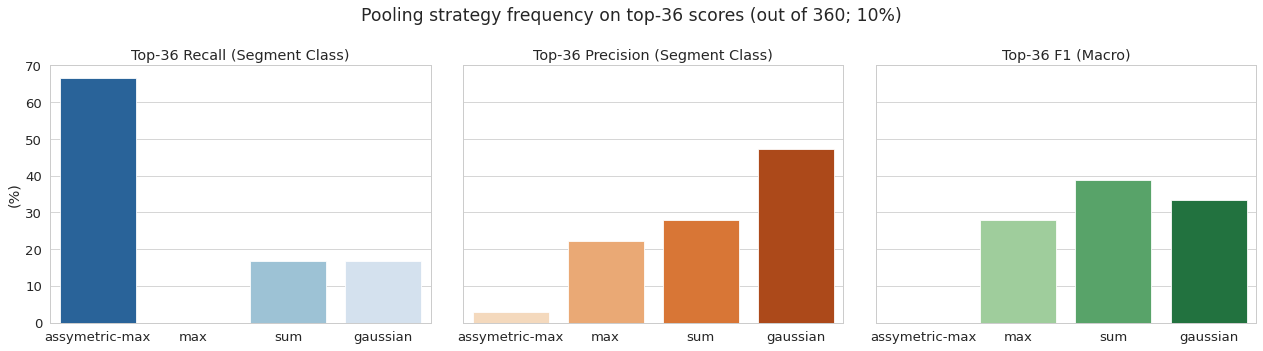

In [182]:
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="crest",
    font_scale=1.5,
)

fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(10 * 16 / 9, 5), sharex="row", sharey=True
)

top_n = 36

recall_1_global = get_rank_by_metric(
    ret,
    metric="per_cls_recall_1",
    algorithm=None,
    return_top_k_indices=top_n,
    min_shift=0.0,
    min_window_size=0,
)

precision_1_global = get_rank_by_metric(
    ret,
    metric="per_cls_precision_1",
    algorithm=None,
    return_top_k_indices=top_n,
    min_shift=0.0,
    min_window_size=0,
)

f1_1_global = get_rank_by_metric(
    ret,
    metric="macro_f1",
    algorithm=None,
    return_top_k_indices=top_n,
    min_shift=0.0,
    min_window_size=0,
)

labels = ("assymetric-max", "max", "sum", "gaussian")


def fill_classes(counter):
    for lab in labels:
        counter.setdefault(lab, 0)

    return counter


recall_top_pooling = collections.Counter([pooling for (_, (_, pooling, *_), _) in recall_1_global])
precision_top_pooling = collections.Counter(
    [pooling for (_, (_, pooling, *_), _) in precision_1_global]
)
f1_top_pooling = collections.Counter(
    [pooling for (_, (_, pooling, *_), _) in f1_1_global]
)

fill_classes(recall_top_pooling)
fill_classes(precision_top_pooling)
fill_classes(f1_top_pooling)


plt_1 = sns.barplot(
    data=[[100 * recall_top_pooling[lab] / top_n] for lab in labels],
    ax=ax1,
    palette="Blues_r",
)

plt_2 = sns.barplot(
    data=[[100 * precision_top_pooling[lab] / top_n] for lab in labels],
    ax=ax2,
    palette="Oranges",
)

plt_3 = sns.barplot(
    data=[[100 * f1_top_pooling[lab] / top_n] for lab in labels],
    ax=ax3,
    palette="Greens",
)

fig.suptitle(f"Pooling strategy frequency on top-{top_n} scores (out of {len(ret)}; {100 * top_n/len(ret):.0f}%)")

ax1.set_xticklabels(labels=labels)
ax1.set_ylabel("(%)")

ax1.set_title(f"Top-{top_n} Recall (Segment Class)")
ax2.set_title(f"Top-{top_n} Precision (Segment Class)")
ax3.set_title(f"Top-{top_n} F1 (Macro)")

plt.tight_layout()
plt.savefig(
    os.path.join(OUTPUT_DIR, f"pooling_strategy_freqs_top_{top_n}.pdf"),
    format="pdf",
    transparent=False,
)